## CU4 Drag Force
- Imports and data preparaton
- Prepare the drag force blockouts for neural net training

### Imports and Data Preparation

First, we must prep our data.

Import the data.

In [1]:
import OpenMORe.OpenMORe.model_order_reduction as model_order_reduction
from OpenMORe.OpenMORe.utilities import *
import pandas as pd
from numpy import genfromtxt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import matplotlib

In [2]:
cu4_concat = genfromtxt('cu4_concat.csv', delimiter=',')

In [3]:
cu4_concat = pd.DataFrame(cu4_concat, columns = ['x','eta','u','v','pressure'])
cu4_concat

,x,eta,u,v,pressure
0,-1.728670,1.594456,0.183840,0.726587,0.725233
1,-1.721907,1.592266,0.258540,0.806480,0.648305
2,-1.715139,1.582960,0.269511,0.808270,0.614005
3,-1.708376,1.568179,0.290845,0.924656,0.542222
4,-1.701608,1.536428,0.301410,0.924826,0.508903
...,...,...,...,...,...
10235,1.701608,1.513993,-1.130897,0.205433,1.193493
10236,1.708376,1.543437,-1.123716,0.359496,1.148804
10237,1.715139,1.580311,-1.125836,0.372134,1.124256
10238,1.721907,1.589667,-1.117356,0.447627,1.075160


In [4]:
cu4_concat['deta_dx'] = cu4_concat['eta'].diff() / cu4_concat['x'].diff()

In [5]:
cu4_concat

,x,eta,u,v,pressure,deta_dx
0,-1.728670,1.594456,0.183840,0.726587,0.725233,NaN
1,-1.721907,1.592266,0.258540,0.806480,0.648305,-0.323798
2,-1.715139,1.582960,0.269511,0.808270,0.614005,-1.375024
3,-1.708376,1.568179,0.290845,0.924656,0.542222,-2.185638
4,-1.701608,1.536428,0.301410,0.924826,0.508903,-4.691257
...,...,...,...,...,...,...
10235,1.701608,1.513993,-1.130897,0.205433,1.193493,2.886742
10236,1.708376,1.543437,-1.123716,0.359496,1.148804,4.350442
10237,1.715139,1.580311,-1.125836,0.372134,1.124256,5.452650
10238,1.721907,1.589667,-1.117356,0.447627,1.075160,1.382383


In [6]:
avg = cu4_concat['pressure'].mean()
avg

4.6837533851373795e-18

In [7]:
cu4_concat['drag_force'] = (cu4_concat['pressure'] - avg) * cu4_concat['deta_dx']

Equation for drag force: sum[(pressure-average(pressure))*deta/dx]. Sum is overall drag force. Which will be used in the loss.

Now, we have a new set of features.

In [8]:
cu4_concat

,x,eta,u,v,pressure,deta_dx,drag_force
0,-1.728670,1.594456,0.183840,0.726587,0.725233,NaN,NaN
1,-1.721907,1.592266,0.258540,0.806480,0.648305,-0.323798,-0.209920
2,-1.715139,1.582960,0.269511,0.808270,0.614005,-1.375024,-0.844272
3,-1.708376,1.568179,0.290845,0.924656,0.542222,-2.185638,-1.185102
4,-1.701608,1.536428,0.301410,0.924826,0.508903,-4.691257,-2.387395
...,...,...,...,...,...,...,...
10235,1.701608,1.513993,-1.130897,0.205433,1.193493,2.886742,3.445307
10236,1.708376,1.543437,-1.123716,0.359496,1.148804,4.350442,4.997804
10237,1.715139,1.580311,-1.125836,0.372134,1.124256,5.452650,6.130174
10238,1.721907,1.589667,-1.117356,0.447627,1.075160,1.382383,1.486284


Save the data.

In [44]:
np.savetxt("cu4_drag_force.csv", cu4_concat, delimiter=",")

### Prepare the drag force blockouts training

In [54]:
cu4_pos_drag = cu4_concat.copy()
cu4_neg_drag = cu4_concat.copy()

# apply filters for drag force
cu4_pos_drag[cu4_pos_drag['deta_dx'] < 0] = 0
cu4_neg_drag[cu4_neg_drag['deta_dx'] > 0] = 0

### Model performance with filtered drag force

1. How well does the model do with predicting unaltered drag force?
2. How well does the model do with predicting positively-filtered drag force?
3. How well does the model do with predicting negatively-filtered drag force?

In [55]:
test_results = {}

#### Unaltered drag force

First, prepare the data. I got rid of the first column because it contains NaN values.

In [9]:
cu4_unaltered = cu4_concat.copy()[1:]
cu4_unaltered

,x,eta,u,v,pressure,deta_dx,drag_force
1,-1.721907,1.592266,0.258540,0.806480,0.648305,-0.323798,-0.209920
2,-1.715139,1.582960,0.269511,0.808270,0.614005,-1.375024,-0.844272
3,-1.708376,1.568179,0.290845,0.924656,0.542222,-2.185638,-1.185102
4,-1.701608,1.536428,0.301410,0.924826,0.508903,-4.691257,-2.387395
5,-1.694840,1.508783,0.371505,0.989968,0.439815,-4.084629,-1.796480
...,...,...,...,...,...,...,...
10235,1.701608,1.513993,-1.130897,0.205433,1.193493,2.886742,3.445307
10236,1.708376,1.543437,-1.123716,0.359496,1.148804,4.350442,4.997804
10237,1.715139,1.580311,-1.125836,0.372134,1.124256,5.452650,6.130174
10238,1.721907,1.589667,-1.117356,0.447627,1.075160,1.382383,1.486284


In [10]:
np.savetxt("viki_test.csv", cu4_unaltered, delimiter=",")

Next, split the data into train and test sets.

In [57]:
train_dataset_cu4_unaltered = cu4_unaltered.sample(frac=0.8, random_state=0)
test_dataset_cu4_unaltered = cu4_unaltered.drop(train_dataset_cu4_unaltered.index)

train_dataset_cu4_unaltered.pop('pressure')
test_dataset_cu4_unaltered.pop('pressure')

train_dataset_cu4_unaltered.pop('deta_dx')
test_dataset_cu4_unaltered.pop('deta_dx')

print("shape of training dataset: ", train_dataset_cu4_unaltered.shape)
print("shape of testing dataset: ", test_dataset_cu4_unaltered.shape)

shape of training dataset:  (8191, 5)
shape of testing dataset:  (2048, 5)


In [58]:
train_features_cu4_unaltered = train_dataset_cu4_unaltered.copy()
test_features_cu4_unaltered = test_dataset_cu4_unaltered.copy()

train_labels_cu4_unaltered = train_features_cu4_unaltered.pop('drag_force')
test_labels_cu4_unaltered = test_features_cu4_unaltered.pop('drag_force')

Normalize the data.

In [59]:
normalizer_cu4_unaltered = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_unaltered.adapt(np.array(train_features_cu4_unaltered))

first = np.array(train_features_cu4_unaltered[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_cu4_unaltered(first).numpy())

First example: [[0.9  1.54 1.13 1.02]]

Normalized: [[0.89 1.54 1.13 1.02]]


Build the model.

In [15]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [16]:
dnn_model_cu4_unaltered = build_and_compile_model(normalizer_cu4_unaltered)
dnn_model_cu4_unaltered.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


Train the model.

In [17]:
%%time
history_cu4_unaltered = dnn_model_cu4_unaltered.fit(
    train_features_cu4_unaltered,
    train_labels_cu4_unaltered,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 36.4 s, sys: 6.35 s, total: 42.7 s
Wall time: 27.2 s


Plot the loss.

In [18]:
def plot_loss(history_concat):
  plt.plot(history_concat.history['loss'], label='loss')
  plt.plot(history_concat.history['val_loss'], label='val_loss')
  plt.ylim([0, 6])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

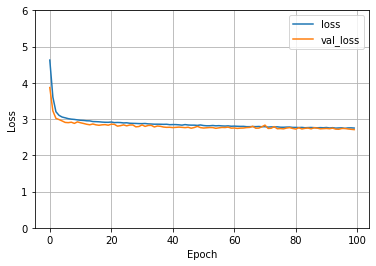

In [19]:
plot_loss(history_cu4_unaltered)

Save the results of the model.

In [20]:
test_results['dnn_model_cu4_unaltered'] = dnn_model_cu4_unaltered.evaluate(test_features_cu4_unaltered, test_labels_cu4_unaltered, verbose=0)

#### Positive drag force

First, prepare the data (including first row with NaN values).

In [109]:
cu4_pos_drag = cu4_pos_drag.copy()[1:]

Then, split the data into train and test sets.

In [110]:
train_dataset_cu4_pos_drag = cu4_pos_drag.sample(frac=0.8, random_state=0)
test_dataset_cu4_pos_drag = cu4_pos_drag.drop(train_dataset_cu4_pos_drag.index)

train_dataset_cu4_pos_drag.pop('pressure')
test_dataset_cu4_pos_drag.pop('pressure')

# train_dataset_cu4_pos_drag.pop('deta_dx')
# test_dataset_cu4_pos_drag.pop('deta_dx')

print("shape of training dataset: ", train_dataset_cu4_pos_drag.shape)
print("shape of testing dataset: ", test_dataset_cu4_pos_drag.shape)

shape of training dataset:  (8190, 6)
shape of testing dataset:  (2047, 6)


In [111]:
train_features_cu4_pos_drag = train_dataset_cu4_pos_drag.copy()
test_features_cu4_pos_drag = test_dataset_cu4_pos_drag.copy()

train_labels_cu4_pos_drag = train_features_cu4_pos_drag.pop('drag_force')
test_labels_cu4_pos_drag = test_features_cu4_pos_drag.pop('drag_force')

Normalize the data.

In [112]:
normalizer_cu4_pos_drag = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_pos_drag.adapt(np.array(train_features_cu4_pos_drag))

first = np.array(train_features_cu4_pos_drag[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_cu4_pos_drag(first).numpy())

First example: [[0. 0. 0. 0. 0.]]

Normalized: [[-0.16 -0.01  0.46  0.41 -0.74]]


Build the model.

In [113]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [114]:
dnn_model_cu4_pos_drag = build_and_compile_model(normalizer_cu4_pos_drag)
dnn_model_cu4_pos_drag.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                384       
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


Train the model.

In [115]:
%%time
history_cu4_pos_drag = dnn_model_cu4_pos_drag.fit(
    train_features_cu4_pos_drag,
    train_labels_cu4_pos_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 39.4 s, sys: 7.58 s, total: 47 s
Wall time: 28.9 s


Plot the loss.

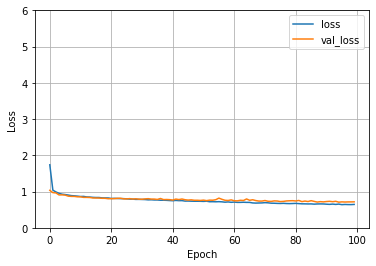

In [116]:
plot_loss(history_cu4_pos_drag)

Save the results of the model.

In [117]:
test_results['dnn_model_cu4_pos_drag'] = dnn_model_cu4_pos_drag.evaluate(test_features_cu4_pos_drag,
                                                                           test_labels_cu4_pos_drag, verbose=0)

#### Negative drag force

I will combine all steps for ease.

In [98]:
# Prepare the data
cu4_neg_drag = cu4_neg_drag.copy()[1:]

# Split the data into train and test
train_dataset_cu4_neg_drag = cu4_neg_drag.sample(frac=0.8, random_state=0)
test_dataset_cu4_neg_drag = cu4_neg_drag.drop(train_dataset_cu4_neg_drag.index)

train_dataset_cu4_neg_drag.pop('pressure')
test_dataset_cu4_neg_drag.pop('pressure')

train_dataset_cu4_neg_drag.pop('deta_dx')
test_dataset_cu4_neg_drag.pop('deta_dx')

print("shape of training dataset: ", train_dataset_cu4_neg_drag.shape)
print("shape of testing dataset: ", test_dataset_cu4_neg_drag.shape)

train_features_cu4_neg_drag = train_dataset_cu4_neg_drag.copy()
test_features_cu4_neg_drag = test_dataset_cu4_neg_drag.copy()

train_labels_cu4_neg_drag = train_features_cu4_neg_drag.pop('drag_force')
test_labels_cu4_neg_drag = test_features_cu4_neg_drag.pop('drag_force')

# Normalize the data
normalizer_cu4_neg_drag = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_neg_drag.adapt(np.array(train_features_cu4_neg_drag))

first = np.array(train_features_cu4_neg_drag[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_cu4_neg_drag(first).numpy())

# Build the model
dnn_model_cu4_neg_drag = build_and_compile_model(normalizer_cu4_neg_drag)
dnn_model_cu4_neg_drag.summary()

shape of training dataset:  (8190, 6)
shape of testing dataset:  (2048, 6)
First example: [[ 0.9   1.5   1.32  1.12 -5.55]]

Normalized: [[ 1.44  2.14  1.62  1.29 -0.48]]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                384       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
____________

Train the model.

In [99]:
%%time
history_cu4_neg_drag = dnn_model_cu4_neg_drag.fit(
    train_features_cu4_neg_drag,
    train_labels_cu4_neg_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 35.7 s, sys: 6.54 s, total: 42.2 s
Wall time: 26.3 s


Plot the loss.

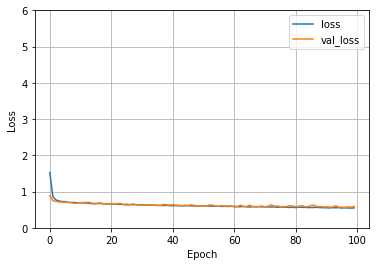

In [101]:
plot_loss(history_cu4_neg_drag)

Save the results of the model.

In [103]:
test_results['dnn_model_cu4_neg_drag'] = dnn_model_cu4_neg_drag.evaluate(test_features_cu4_neg_drag,
                                                                           test_labels_cu4_neg_drag, verbose=0)

### Analyzing the low loss.

Why is the loss so low? What does the data look like? It's very predictable.

<AxesSubplot:xlabel='x', ylabel='drag_force'>

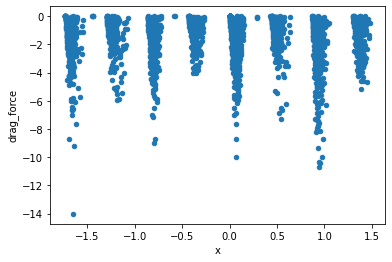

In [110]:
cu4_neg_drag.plot.scatter(x="x", y="drag_force")

Let's compare this to the positive drag force alternative.

<AxesSubplot:xlabel='x', ylabel='drag_force'>

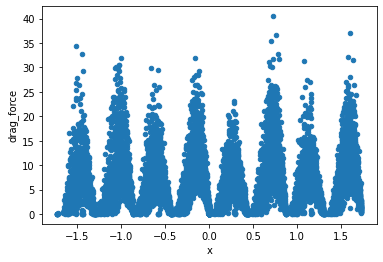

In [111]:
cu4_pos_drag.plot.scatter(x="x", y="drag_force")

This is also very predictable, so it is unclear why the model WAS doing so much better on the neg drag force than the pos drag force (when the drag force was literally just drag force is + vs -)... Mueller offered a physical explanation at last meeting, then we changed the criterion for +/- forces and the model performed much closer to what was expected :)

### Compare the DNNs for drag force

In [118]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_model_cu4_unaltered,2.923618
dnn_model_cu4_pos_drag,0.790938
dnn_model_cu4_neg_drag,0.586595


The model seems to be much better at predicting the negative drag than the alternatives. Our idea that negative drag is easier to predict than positive drag MAY still hold (MGS: 1.44 > 1.16), but who knows if the error is just from the way that the data was sampled, or if it's from an actual difference in the learnability of the function...

Also, if you train and include the deta_dx feature, the mean absolute errors drop significantly!

- dnn_model_cu4_pos_drag yields an error of 0.790938
- dnn_model_cu4_neg_drag yields an error of 0.586595

This makes me think that the model, for some reason, isn't learning the deta_dx relationship, even though it was given both eta and x! Strange because DNNs are supposedly a universal function approximator, and they were given all of the relevant information...

### Correlation analysis

Pressure vs. deta_dx. First, we will do a simple plot.

<AxesSubplot:xlabel='pressure', ylabel='deta_dx'>

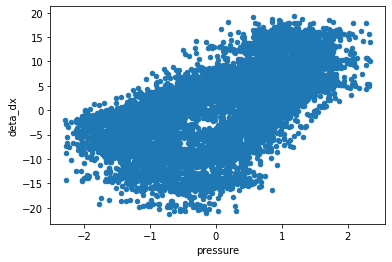

In [76]:
cu4_unaltered.plot.scatter(x="pressure",y="deta_dx")

Physical interpretation: agrees with Figure 1 from Nov 4 notes on Notability.

Correlation is 0.644. Since it is >0.5, we can say that they are positively/highly(?) correlated.

In [77]:
corr, _ = pearsonr(cu4_unaltered['deta_dx'], cu4_unaltered['pressure'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.644


Drag force vs. deta_dx. Here is the simple plot:

<AxesSubplot:xlabel='deta_dx', ylabel='drag_force'>

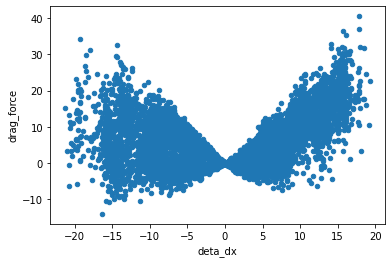

In [78]:
cu4_unaltered.plot.scatter(x="deta_dx",y="drag_force")

Different relationships for if deta_dx is positive vs. negative. That is why it is useful to apply the filter and learn the two different relationships.

Before, PCA feature selection removed eta. When you replace eta with deta_dx, what gets selected out? deta_dx does. We will use the procrustes algorithm.

In [79]:
pressure_feat_sel = cu4_concat[['x','deta_dx','u','v','pressure']][1:]

In [80]:
# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(pressure_feat_sel)
pressure_feat_sel_std = sc.transform(pressure_feat_sel)
pressure_feat_sel_std.shape

(10239, 5)

In [81]:
# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 3,
    "number_of_variables"       : 4
}

In [82]:
PVs = model_order_reduction.variables_selection(pressure_feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 4
[0 2 3 4]


Recall that the index 1 corresponds to deta_dx (as verified in the following printout). That means that deta_dx is still selected out, which is surprising to me. Why could it be? Before, we saw a roughly linear relationship between pressure and deta_dx, and a Pearson's correlation coefficient that could be considered strong. Let's see what's selected out when we do feature selection using drag force instead of pressure.

In [87]:
pressure_feat_sel

,x,deta_dx,u,v,pressure
1,-1.721907,-0.323798,0.258540,0.806480,0.648305
2,-1.715139,-1.375024,0.269511,0.808270,0.614005
3,-1.708376,-2.185638,0.290845,0.924656,0.542222
4,-1.701608,-4.691257,0.301410,0.924826,0.508903
5,-1.694840,-4.084629,0.371505,0.989968,0.439815
...,...,...,...,...,...
10235,1.701608,2.886742,-1.130897,0.205433,1.193493
10236,1.708376,4.350442,-1.123716,0.359496,1.148804
10237,1.715139,5.452650,-1.125836,0.372134,1.124256
10238,1.721907,1.382383,-1.117356,0.447627,1.075160


In [85]:
drag_force_feat_sel = cu4_concat[['x','deta_dx','u','v','drag_force']][1:]

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(drag_force_feat_sel)
drag_force_feat_sel_std = sc.transform(drag_force_feat_sel)
drag_force_feat_sel_std.shape

(10239, 5)

In [86]:
PVs = model_order_reduction.variables_selection(drag_force_feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 4
[0 2 3 4]


Interestingly enough, deta_dx is selected out here! I would have expected it not to be, since we hypothesized that it is so important for the drag force predictions. Let's take drag force and pressure out and see if deta_dx is still selected out.

In [90]:
feat_sel = cu4_concat[['x','deta_dx','u','v']][1:]

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(feat_sel)
feat_sel_std = sc.transform(feat_sel)
feat_sel_std.shape

# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 2,
    "number_of_variables"       : 3
}

PVs = model_order_reduction.variables_selection(feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 3
[0 1 2]


Here, v is selected out. That must mean that deta_dx captures relatively more variance in the data. So when you put drag force/pressure back in, the face that deta_dx is selected out must mean that they are highly correlated, since most of the information can be retained after removing deta_dx.

### Thought experiment: training solely on deta_dx information.

In [12]:
cu4_concat

,x,eta,u,v,pressure,deta_dx,drag_force
0,-1.728670,1.594456,0.183840,0.726587,0.725233,NaN,NaN
1,-1.721907,1.592266,0.258540,0.806480,0.648305,-0.323798,-0.209920
2,-1.715139,1.582960,0.269511,0.808270,0.614005,-1.375024,-0.844272
3,-1.708376,1.568179,0.290845,0.924656,0.542222,-2.185638,-1.185102
4,-1.701608,1.536428,0.301410,0.924826,0.508903,-4.691257,-2.387395
...,...,...,...,...,...,...,...
10235,1.701608,1.513993,-1.130897,0.205433,1.193493,2.886742,3.445307
10236,1.708376,1.543437,-1.123716,0.359496,1.148804,4.350442,4.997804
10237,1.715139,1.580311,-1.125836,0.372134,1.124256,5.452650,6.130174
10238,1.721907,1.589667,-1.117356,0.447627,1.075160,1.382383,1.486284


In [14]:
dataset = cu4_concat.copy()

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print("shape of training dataset: ", train_dataset.shape)
print("shape of testing dataset: ", test_dataset.shape)

shape of training dataset:  (8192, 7)
shape of testing dataset:  (2048, 7)


In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('drag_force')
test_labels = test_features.pop('drag_force')

In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

2022-11-07 08:34:36.796250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First example: [[ -0.58  -0.73   1.     0.6   -1.54 -14.4 ]]

Normalized: [[-0.58 -0.73  1.    0.6  -1.55 -1.81]]


In [19]:
x = np.array(train_features['deta_dx'])

x_normalizer = layers.Normalization(input_shape=[1,], axis=None)
x_normalizer.adapt(x)

In [20]:
x_model = tf.keras.Sequential([
    x_normalizer,
    layers.Dense(units=1)
])

x_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [21]:
x_model.predict(x[:10])

1/1 [==============================] - 0s 84ms/step


array([[-0.17651953],
       [-0.10570055],
       [-0.05949053],
       [-0.06468363],
       [-0.02050079],
       [ 0.14711009],
       [ 0.08906706],
       [ 0.10864361],
       [ 0.10547416],
       [-0.07440124]], dtype=float32)

In [22]:
x_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

In [24]:
%%time
history = x_model.fit(
    train_features['deta_dx'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 29.1 s, sys: 3.27 s, total: 32.4 s
Wall time: 24.3 s


In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,4.727084,4.737648,95
96,4.726821,4.738096,96
97,4.727800,4.738259,97
98,4.726594,4.737060,98
99,4.726753,4.738211,99


In [34]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([4.7, 5])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

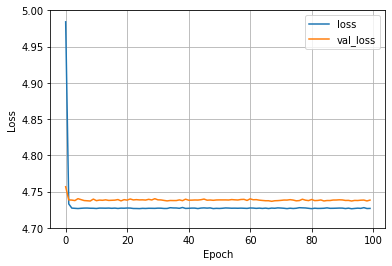

In [35]:
plot_loss(history)

We can see that this model did not perform nearly as well as compared to the others! This is expected, since it's only linear regression on one variable. Similarly to the results in the cu4_regressions_technique notebook, the regression is pretty uninformative.

### PCA selection on filtered drag force data

Before, we saw that deta_dx was selected out when PCA feature selection was run on all features (x, deta_dx, u, v, pressure/drag_force), where drag force was not filtered. Now, we will examine the PCA features selection results on the same features, but this time with drag force filtered out.

The following code block shows that deta_dx is selected out when running PCA feature selection on the positive drag data.

In [66]:
pos_drag_feat_sel = cu4_pos_drag[['x','deta_dx','u','v','drag_force']][1:]

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(pos_drag_feat_sel)
pos_drag_feat_sel_std = sc.transform(pos_drag_feat_sel)
pos_drag_feat_sel_std.shape

# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 3,
    "number_of_variables"       : 4
}

PVs = model_order_reduction.variables_selection(pos_drag_feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 4
[0 2 3 4]


The following code block shows that deta_dx is also selected out when running PCA feature selection on the negative drag data.

In [68]:
neg_drag_feat_sel = cu4_neg_drag[['x','deta_dx','u','v','drag_force']][1:]

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(neg_drag_feat_sel)
neg_drag_feat_sel_std = sc.transform(neg_drag_feat_sel)
neg_drag_feat_sel_std.shape

# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 3,
    "number_of_variables"       : 4
}

PVs = model_order_reduction.variables_selection(neg_drag_feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 4
[0 2 3 4]


What about when we replace deta_dx back with just eta? Eta is taken out in both cases as well.

In [69]:
pos_drag_feat_sel = cu4_pos_drag[['x','eta','u','v','drag_force']][1:]

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(pos_drag_feat_sel)
pos_drag_feat_sel_std = sc.transform(pos_drag_feat_sel)
pos_drag_feat_sel_std.shape

# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 3,
    "number_of_variables"       : 4
}

PVs = model_order_reduction.variables_selection(pos_drag_feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 4
[0 2 3 4]


In [70]:
neg_drag_feat_sel = cu4_neg_drag[['x','eta','u','v','drag_force']][1:]

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(neg_drag_feat_sel)
neg_drag_feat_sel_std = sc.transform(neg_drag_feat_sel)
neg_drag_feat_sel_std.shape

# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 3,
    "number_of_variables"       : 4
}

PVs = model_order_reduction.variables_selection(neg_drag_feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 4
[0 2 3 4]


What about when drag_force is removed as a feature (we already know that drag force and eta have a high correlation)? In the case of positive drag force, x is removed as a feature. In the case of negative drag force, x is also removed as a feature. There doesn't seem to be a huge difference here.

In [74]:
pos_drag_feat_sel = cu4_pos_drag[['x','eta','u','v']][1:]

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(pos_drag_feat_sel)
pos_drag_feat_sel_std = sc.transform(pos_drag_feat_sel)
pos_drag_feat_sel_std.shape

# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 2,
    "number_of_variables"       : 3
}

PVs = model_order_reduction.variables_selection(pos_drag_feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 3
[1 2 3]


In [75]:
neg_drag_feat_sel = cu4_neg_drag[['x','eta','u','v']][1:]

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(neg_drag_feat_sel)
neg_drag_feat_sel_std = sc.transform(neg_drag_feat_sel)
neg_drag_feat_sel_std.shape

# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 2,
    "number_of_variables"       : 3
}

PVs = model_order_reduction.variables_selection(neg_drag_feat_sel_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 3
[1 2 3]


The conclusion is that the same features get selected out in the two drag force filtering scenarios. Not much to be learned about any relationships here.

### PCA extraction on filtered drag force data

I wonder if PCA extraction gives similar principal components. Are the features weighed the same in terms of principal components (between positive and negative drag force filters)?

In [85]:
feat_sel = cu4_pos_drag[['x','eta','u','v','drag_force']][1:]

In [86]:
sc = StandardScaler()
sc.fit(feat_sel)
feat_sel_std = sc.transform(feat_sel)
feat_sel_std.shape

(10239, 5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


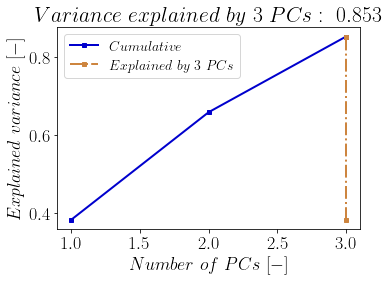

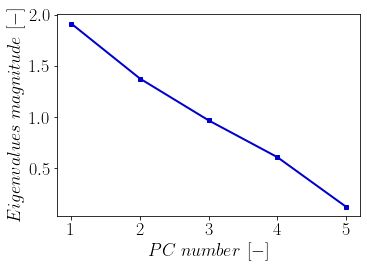

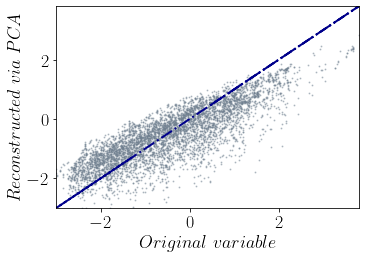

In [87]:
# Dictionary with the instruction for the PCA algorithm:
settings ={
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the final dimensionality
    "number_of_eigenvectors"    : 3,
    
    #enable to plot the cumulative explained variance
    "enable_plot_variance"      : True,
    
    #set the number of the variable whose reconstruction must be plotted
    "variable_to_plot"          : 2,

}

# Start the dimensionality reduction and the feature extraction step:
# call the PCA class and give in input X and the dictionary with the instructions
model = model_order_reduction.PCA(feat_sel_std, settings)

# Perform the dimensionality reduction via Principal Component Analysis,
# and return the eigenvectors of the reduced manifold 
PCs = model.fit()

# Compute the projection of the original points on the reduced
# PCA manifold, obtaining the scores matrix Z
Z = model.get_scores()

# Assess the percentage of explained variance if the number of PCs has not
# been set automatically, and plot the result
model.get_explained()

# Reconstruct the matrix from the reduced PCA manifold
X_recovered = model.recover()

# Compare the reconstructed chosen variable "set_num_to_plot" with the
# original one, by means of a parity plot
model.plot_parity()

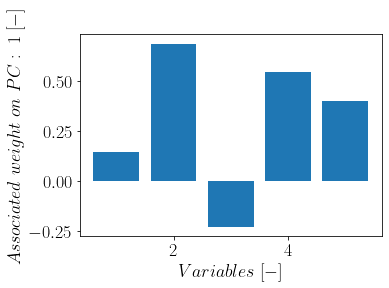

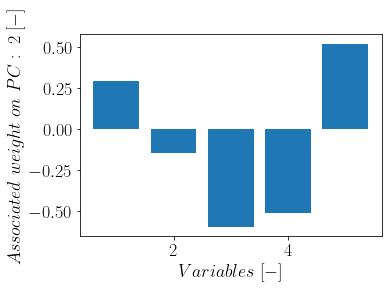

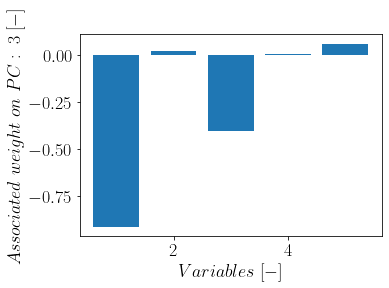

In [90]:
for i in range (0, settings["number_of_eigenvectors"]):
    matplotlib.rcParams.update({'font.size' : 18, 'text.usetex' : True})
    fig = plt.figure()
    axes = fig.add_axes([0.15,0.15,0.7,0.7], frameon=True)
    x = np.linspace(1, feat_sel_std.shape[1], feat_sel_std.shape[1])
    axes.bar(x, PCs[0][:,i])
    axes.set_xlabel('$Variables\ [-]$')
    axes.set_ylabel('$Associated\ weight\ on\ PC:\ {}\ [-]$'.format(i + 1))
    plt.show()

Now, we will produce the same output, but for negative-filtered drag.

In [91]:
feat_sel = cu4_neg_drag[['x','eta','u','v','drag_force']][1:]

In [93]:
sc = StandardScaler()
sc.fit(feat_sel)
feat_sel_std = sc.transform(feat_sel)
feat_sel_std.shape

(10239, 5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


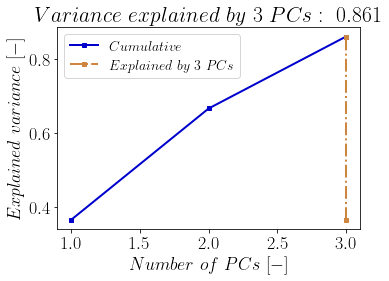

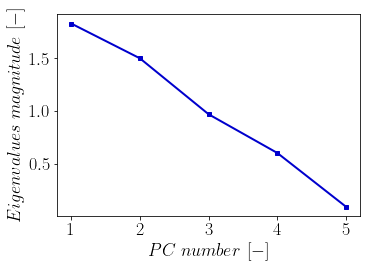

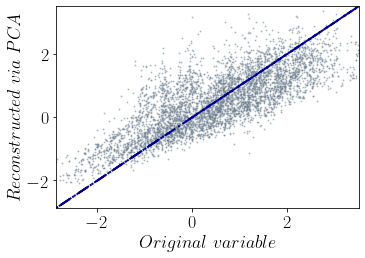

In [94]:
# Dictionary with the instruction for the PCA algorithm:
settings ={
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the final dimensionality
    "number_of_eigenvectors"    : 3,
    
    #enable to plot the cumulative explained variance
    "enable_plot_variance"      : True,
    
    #set the number of the variable whose reconstruction must be plotted
    "variable_to_plot"          : 2,

}

# Start the dimensionality reduction and the feature extraction step:
# call the PCA class and give in input X and the dictionary with the instructions
model = model_order_reduction.PCA(feat_sel_std, settings)

# Perform the dimensionality reduction via Principal Component Analysis,
# and return the eigenvectors of the reduced manifold 
PCs = model.fit()

# Compute the projection of the original points on the reduced
# PCA manifold, obtaining the scores matrix Z
Z = model.get_scores()

# Assess the percentage of explained variance if the number of PCs has not
# been set automatically, and plot the result
model.get_explained()

# Reconstruct the matrix from the reduced PCA manifold
X_recovered = model.recover()

# Compare the reconstructed chosen variable "set_num_to_plot" with the
# original one, by means of a parity plot
model.plot_parity()

The set of 5 principal components can explain slightly more variance in the overall data when drag force is negative than when its postive (83% versus 86%). This matches the output of our DNNs, which was that the MAE (mean absolute error) was slightly lower when predicting negative drag versus positive drag. This also matches a physical explanation. Let's say that the wind is going in the rightwards direction over the waves. Then, on the LHS of he waves, you have an easier relationship to learn (only negative drag forces are applied). On the RHS of the waves, the relationship is harder to learn because you have the eddies in the wind (positive and negative drag forces are applied).

Let's see if the principal components are constructed in relatively the same way as well.

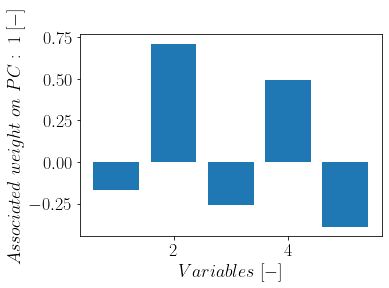

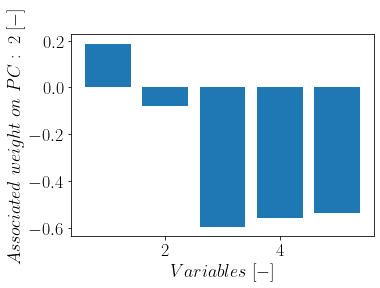

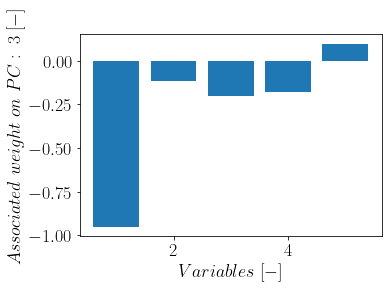

In [95]:
for i in range (0, settings["number_of_eigenvectors"]):
    matplotlib.rcParams.update({'font.size' : 18, 'text.usetex' : True})
    fig = plt.figure()
    axes = fig.add_axes([0.15,0.15,0.7,0.7], frameon=True)
    x = np.linspace(1, feat_sel_std.shape[1], feat_sel_std.shape[1])
    axes.bar(x, PCs[0][:,i])
    axes.set_xlabel('$Variables\ [-]$')
    axes.set_ylabel('$Associated\ weight\ on\ PC:\ {}\ [-]$'.format(i + 1))
    plt.show()

Although not exactly the same, they look pretty similar! The difference is mostly in variable 5, which is drag force. The reason why the drag force is flipped between the two is because drag force is negative in one dataset and positive in the other, by construction. Therefore, if you consider the absolute value of the drag force, you can see that the principal components are constructed in relatively similar ways. I was hoping that this analysis would shed more light onto the physical difference between predicting the +/- drag forces, but ah well.